In [1]:
import os
import shutil
import sys
import time
from PIL import Image
from datetime import date, datetime, timedelta


sys.path.insert(0, '..')
from utils import mongodb

In [2]:
from pesagensbalanca import cursor_pesagensbalanca, extract_to

### Generate pesagens database
Necessário acesso ao Banco de Dados ou ao Servidor

In [3]:
start = datetime(2020, 3, 1)
end = datetime.today()
limit = 10
s0 = time.time()
# cursor = cursor_pesagensbalanca(mongodb, start, end, limit, crop=True)
# count = extract_to(cursor, crop=True)
s1 = time.time()
# print('{:0.2f} segundos para processar {:d} registros'.format((s1 - s0), count))


## Carregar e montar modelo

In [4]:
import pandas as pd
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

from model01 import model

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 144, 288, 16)      1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 72, 72, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 72, 72, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        1

In [6]:
model.load_weights('gerabasesvazios_cropped_tunned.hdf5')


In [6]:
x = layers.Dense(256, use_bias=False)(model.get_layer('flatten').output)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(1, activation='linear')(x)
x = layers.Dense(256, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(1)(x)
regression_model = models.Model(inputs=model.input, outputs=x)
#for layer in regression_model.layers[:-3]:
#    layer.trainable = False
regression_model.compile(loss='mae', optimizer='adam')


In [ ]:
x = layers.Dense(512)(model.get_layer('flatten').output)
x = layers.Dense(1)(x)
regression_model = models.Model(inputs=model.input, outputs=x)
for layer in regression_model.layers[:-3]:
    layer.trainable = False
regression_model.compile(loss='mae', optimizer='adam')


In [7]:
regression_model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 144, 288, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 144, 288, 16)      1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 72, 72, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 72, 72, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 32)        0     

In [8]:
for layer in regression_model.layers:
    print(layer, layer.trainable)


<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f78cf320908> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f792daa3ef0> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f78cfb7fef0> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f78cf312128> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f78cf312278> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f78cf3126d8> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f78cf3128d0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f78cf3129e8> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f78cf312e48> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f78cf319080> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f78cf319198> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f78cf3195f8> True
<tensorflow.py

## Carregar e montar dados para treinamento

In [9]:
df = pd.read_csv('../../bases/pesagensbalanca/pesos.txt')
df['dif'] = abs(df['pesobalanca'] - df['pesodeclarado'])
df['filename'] = df['id'].map('{}.jpg'.format)
df.head()

,id,pesobalanca,pesodeclarado,dif,filename
0,5e5d096a3d0ec8337863f799,7170,7167,3,5e5d096a3d0ec8337863f799.jpg
1,5e5d09703d0ec8337863f9ee,29190,29149,41,5e5d09703d0ec8337863f9ee.jpg
2,5e5d09703d0ec8337863f9f2,6380,6348,32,5e5d09703d0ec8337863f9f2.jpg
3,5e5d099986556b3036c6dc6d,7610,7788,178,5e5d099986556b3036c6dc6d.jpg
4,5e5d094386556b3036c6dc5c,22280,22300,20,5e5d094386556b3036c6dc5c.jpg


In [10]:
df.describe()

,pesobalanca,pesodeclarado,dif
count,9317.000000,9317.000000,9317.000000
mean,18572.832027,18807.056349,1162.008801
std,8261.590188,8106.655375,3793.829146
min,0.000000,2070.000000,0.000000
25%,11300.000000,11453.000000,72.000000
50%,19600.000000,19960.000000,175.000000
75%,25270.000000,25575.000000,446.000000
max,113350.000000,41388.000000,94730.000000


In [11]:
df[df['dif'] < 4000]['dif'].count() # Pegar somente os pesos que batem declarado x balança

8734

In [12]:
df[df['dif'] < 1000]['dif'].count() # Pegar somente os pesos que batem declarado x balança

8104

In [13]:
df_filtered = df[df['dif'] < 1000]
splitmask = np.random.rand(len(df_filtered)) < 0.9
df_train = df_filtered[splitmask]
df_val = df_filtered[~splitmask]

In [14]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory='../../bases/pesagensbalanca/pesagensbalanca_cropped',
    target_size=(144, 288),
    batch_size=64,
    x_col='filename',
    y_col="pesobalanca",
    shuffle=False,
    class_mode='other' 
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=df_val,
    directory='../../bases/pesagensbalanca/pesagensbalanca_cropped',
    target_size=(144, 288),
    batch_size=64,
    x_col='filename',
    y_col="pesobalanca",
    shuffle=False,
    class_mode='other' 
)

Found 7347 validated image filenames.
Found 757 validated image filenames.


## Train 

In [15]:
regression_model.compile(optimizer=optimizers.Adam(lr=0.001),
                         loss='mean_absolute_error', metrics=['mse', 'mae'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4,
                          verbose=1, min_delta=1e-2, mode='min')

In [16]:
regression_model.fit(train_generator, epochs=50,
                     callbacks=[reduce_lr],
                   validation_data = val_generator,
                   validation_steps = val_generator.samples // 64)

Train for 115 steps, validate for 11 steps
Epoch 1/50
115/115 [==============================] - 289s 3s/step - loss: 417135614.7671 - mse: 417172448.0000 - mae: 18811.0645 - val_loss: 408262760.7273 - val_mse: 408262752.0000 - val_mae: 18442.7734
Epoch 2/50
115/115 [==============================] - 158s 1s/step - loss: 416270171.9539 - mse: 416306784.0000 - mae: 18789.5723 - val_loss: 406916331.6364 - val_mse: 406916320.0000 - val_mae: 18406.3965
Epoch 3/50
115/115 [==============================] - 119s 1s/step - loss: 414930489.4598 - mse: 414968448.0000 - mae: 18755.9609 - val_loss: 405158882.9091 - val_mse: 405158880.0000 - val_mae: 18364.1738
Epoch 4/50
115/115 [==============================] - 119s 1s/step - loss: 413000157.1608 - mse: 413039072.0000 - mae: 18708.2930 - val_loss: 403102141.0909 - val_mse: 403102112.0000 - val_mae: 18312.2168
Epoch 5/50
115/115 [==============================] - 113s 984ms/step - loss: 410454471.0602 - mse: 410491360.0000 - mae: 18645.8438 - va

115/115 [==============================] - 84s 730ms/step - loss: 152310640.8246 - mse: 152348656.0000 - mae: 10425.7344 - val_loss: 141183816.0000 - val_mse: 141183808.0000 - val_mae: 9982.8340
Epoch 41/50
115/115 [==============================] - 84s 726ms/step - loss: 145746650.9507 - mse: 145777152.0000 - mae: 10176.3672 - val_loss: 138993925.0909 - val_mse: 138993920.0000 - val_mae: 9903.4805
Epoch 42/50
115/115 [==============================] - 94s 821ms/step - loss: 138559041.0805 - mse: 138583008.0000 - mae: 9892.7236 - val_loss: 133025816.0000 - val_mse: 133025800.0000 - val_mae: 9666.2490
Epoch 43/50
115/115 [==============================] - 81s 708ms/step - loss: 132266096.2794 - mse: 132295784.0000 - mae: 9649.6162 - val_loss: 130847355.6364 - val_mse: 130847368.0000 - val_mae: 9577.7109
Epoch 44/50
115/115 [==============================] - 78s 682ms/step - loss: 126130238.6831 - mse: 126152192.0000 - mae: 9405.1953 - val_loss: 117415323.6364 - val_mse: 117415320.0000 -

In [17]:
model.save_weights('gerabasespesagens_cropped.hdf5')

10863.692 14280


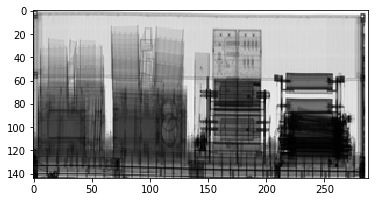

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
sample = df.sample()
filename = sample['filename'].item()
image = Image.open('../../bases/pesagensbalanca/pesagensbalanca_cropped/' + filename)
image = image.resize((288, 144), Image.LANCZOS)
image_array = np.expand_dims(np.array(image), axis=0) / 255
print(regression_model.predict(image_array)[0][0], sample['pesobalanca'].item())
plt.imshow(image)